Installing the necessary dependencies 

In [ ]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib

Listing all the dependencies for rechecking

In [ ]:
!pip list

importing the dependencies 

In [1]:
import tensorflow as tf
import os

Setting GPU memory consumption growth to prevent OOM error

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Data Preprocessing

Found 262 files belonging to 2 classes.


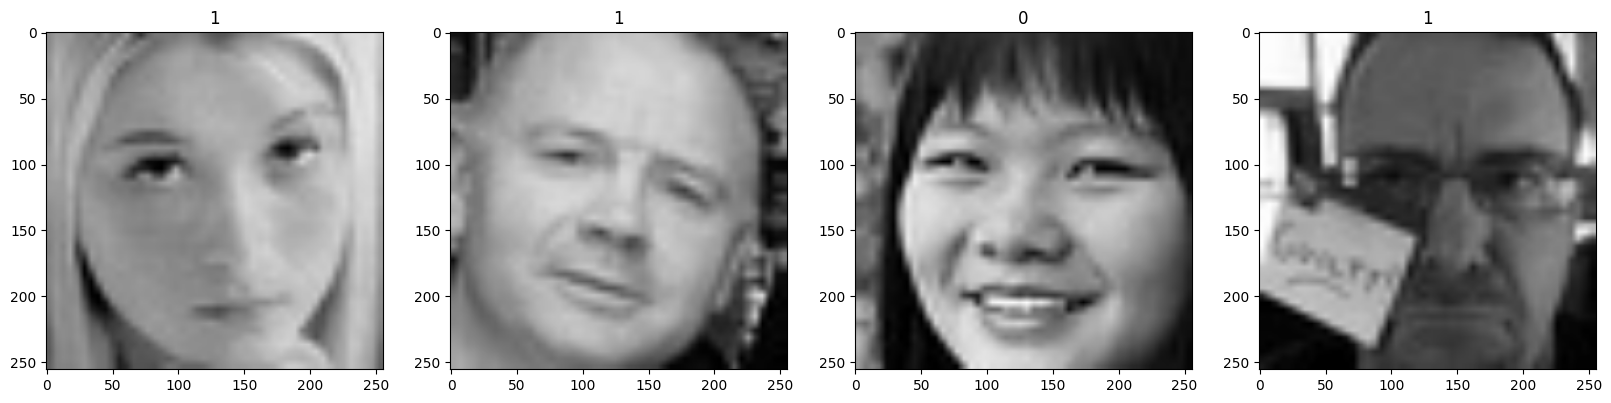

In [4]:
import cv2
import imghdr
##assigining the name of the directory to a variable
data_dir = 'data'
##possible extensions
image_exts= ['jpeg', 'jpg', 'bmp', 'png']
##removing corrupted or incompatibe files 
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir,image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)
import numpy as np
from matplotlib import pyplot as plt
data = tf.keras.utils.image_dataset_from_directory('data')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig,ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
##Scaling the Data
data = data.map(lambda x, y: (x/255, y))
data.as_numpy_iterator()

Spliting the data

In [5]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1) + 1
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Building the deep learning model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)      

Training the model

In [7]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


6/6 [==============================] - 4s 312ms/step - loss: 1.0918 - accuracy: 0.4896 - val_loss: 0.7490 - val_accuracy: 0.4062
Epoch 2/20
6/6 [==============================] - 2s 273ms/step - loss: 0.6890 - accuracy: 0.4948 - val_loss: 0.6759 - val_accuracy: 0.7500
Epoch 3/20
6/6 [==============================] - 2s 321ms/step - loss: 0.6854 - accuracy: 0.6094 - val_loss: 0.6747 - val_accuracy: 0.7500
Epoch 4/20
6/6 [==============================] - 2s 307ms/step - loss: 0.6898 - accuracy: 0.5417 - val_loss: 0.6978 - val_accuracy: 0.4375
Epoch 5/20
6/6 [==============================] - 2s 305ms/step - loss: 0.6795 - accuracy: 0.6510 - val_loss: 0.6589 - val_accuracy: 0.7500
Epoch 6/20
6/6 [==============================] - 2s 288ms/step - loss: 0.6677 - accuracy: 0.6458 - val_loss: 0.6262 - val_accuracy: 0.6250
Epoch 7/20
6/6 [==============================] - 2s 282ms/step - loss: 0.6815 - accuracy: 0.5781 - val_loss: 0.6505 - val_accuracy: 0.7500
Epoch 8/20
6/6 [==

Plotting the performance

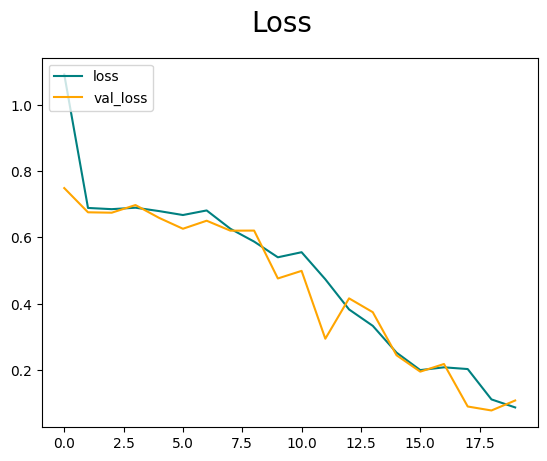

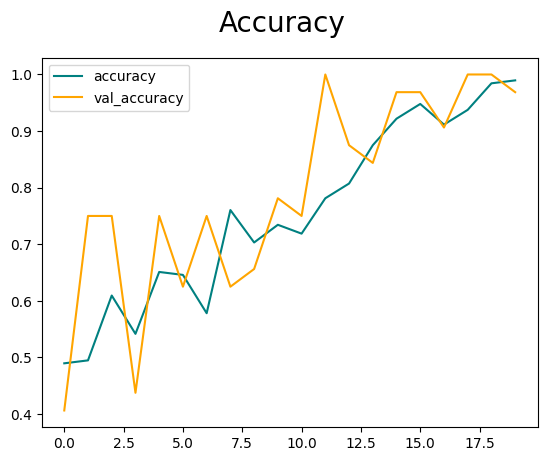

In [8]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluating the model

In [9]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())

1/1 [==============================] - 0s 230ms/step
tf.Tensor(0.875, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9375, shape=(), dtype=float32)


Saving the model

In [10]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models', 'the_image_classifier.h5'))

c:\Users\nikhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
